In [1]:
import os 
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import numpify
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch

In [2]:
dict_path = "/Users/jiayizhang/Documents/code_base/rnn-coach/"
task_name = "ALM"
activation = "relu"
config_dict = json.load(open(os.path.join(dict_path, "data", "configs", f'train_config_{task_name}_{activation}_lambda_orth=0.json'), mode="r"))
print("config file last updated: ", config_dict["last_compiled"])

config file last updated:  2024-02-12 17:06:39.008962


In [3]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]
input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]

# intialize task
task = eval("Task" + task_name)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

# Trainer:
lambda_orth = config_dict["lambda_orth"]
orth_input_only = config_dict["orth_input_only"]
lambda_r = config_dict["lambda_r"]
max_iter = config_dict["max_iter"]
tol = config_dict["tol"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
same_batch = config_dict["same_batch"]

In [4]:
print(lambda_orth, max_iter, orth_input_only)

0 5000 False


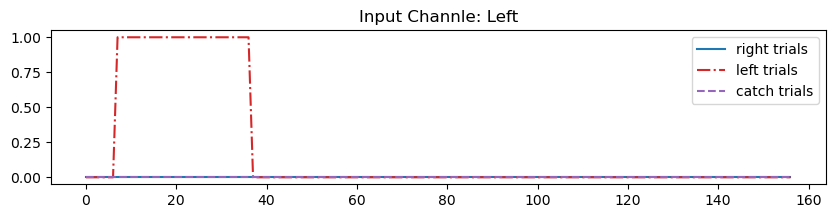

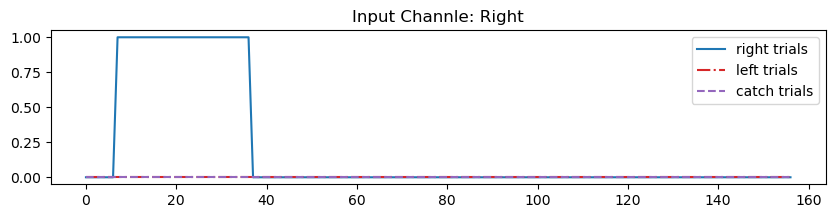

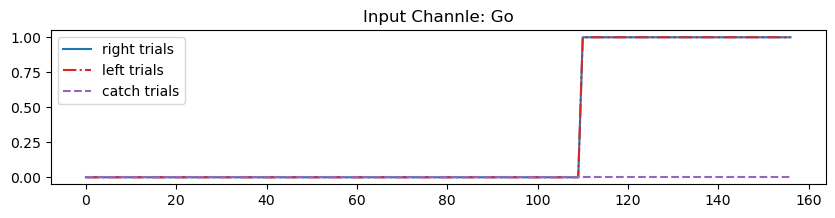

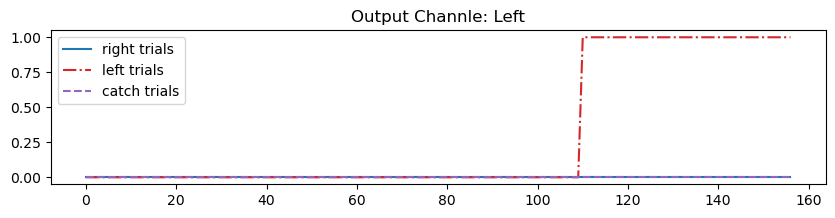

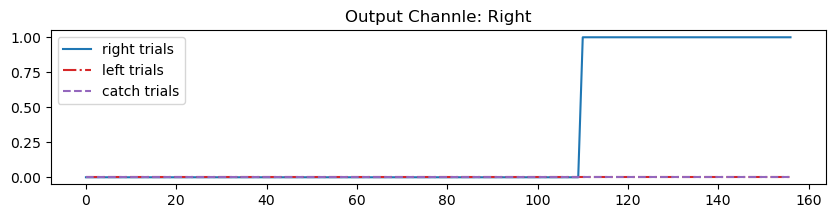

In [5]:
# visualize inputs and targets
inputs, targets = task.get_batch()
n_r, n_l = task_params["n_rights"], task_params["n_lefts"]
n_c = task_params["n_catches"]
channel_names = ["Left", "Right", "Go"]

for i in range(input_size):  # left, right, go
    fig = plt.figure(figsize = (10, 2))
    plt.plot(np.average(inputs[i,:,:n_r], axis=1), c='tab:blue', label="right trials")
    plt.plot(np.average(inputs[i,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left trials")
    plt.plot(np.average(inputs[i,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch trials")
    plt.title(f"Input Channle: {channel_names[i]}")
    plt.legend()

for i in range(output_size): # left, right
    fig = plt.figure(figsize = (10, 2))
    plt.plot(np.average(targets[i,:,:n_r], axis=1), c='tab:blue', label="right trials")
    plt.plot(np.average(targets[i,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left trials")
    plt.plot(np.average(targets[i,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch trials")
    plt.title(f"Output Channle: {channel_names[i]}")
    plt.legend()


In [6]:
# RNN config:
N = config_dict["N"]
dt = config_dict["dt"]
tau = config_dict["tau"]
mask = np.array(config_dict["mask"])

if (activation == "relu"):
    activation = lambda x: torch.maximum(x, torch.tensor(0))
constrained = config_dict["constrained"]
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
connectivity_density_rec = config_dict["connectivity_density_rec"]
spectral_rad = config_dict["sr"]
seed = config_dict["seed"]

In [7]:
n_models = 1 # train this many RNNs
# save models here
model_path = os.path.join("../data/trained_RNNs/ALM/","batch_RNNs_0212")
if not os.path.exists(model_path): os.makedirs(model_path)

## BATCH TRAINING!

In [8]:
for i in range(n_models):
    # creating instances:
    rng = torch.Generator()
    if not (seed is None):
        rng.manual_seed(seed)

    rnn_torch = RNN_torch(N=N, dt=dt, tau=tau, input_size=input_size,   
                        output_size=output_size,
                        activation=activation, constrained=constrained,
                        sigma_inp=sigma_inp, sigma_rec=sigma_rec,
                        connectivity_density_rec=connectivity_density_rec,
                        spectral_rad=spectral_rad,
                        random_generator=rng, device="cpu")

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(rnn_torch.parameters(),
                                lr=lr,
                                weight_decay=weight_decay)
    trainer = Trainer(RNN=rnn_torch, Task=task,
                    max_iter=max_iter, tol=tol,
                    optimizer=optimizer, criterion=criterion,
                    lambda_orth=lambda_orth, lambda_r=lambda_r,
                    orth_input_only=orth_input_only)
    datasaver = None

    # inspect start eigenvalue distribution for the RNN
    w, v = torch.linalg.eig(rnn_torch.W_rec)
    rad = torch.absolute(w).detach().numpy()
    plt.scatter(range(len(rad)), rad)
    plt.savefig(model_path+f"/spectral_{i}.png")
    plt.close()
    
    # run training
    rnn_trained, train_losses, val_losses, net_params = trainer.run_training(train_mask=mask, same_batch=same_batch)

    # visualize loss
    fig_trainloss = plt.figure(figsize=(10, 3))
    plt.plot(train_losses, color='r', label='train loss (log scale)')
    plt.plot(val_losses, color='b', label='valid loss (log scale)')
    plt.yscale("log")
    plt.grid(True)
    plt.xlabel("# epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(fontsize=16)
    plt.savefig(model_path+f"/loss_{i}.png")
    plt.close()

    # validate
    RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=net_params["W_inp"],
                      W_rec=net_params["W_rec"],
                      W_out=net_params["W_out"],
                      bias_rec=np.zeros(N),
                      y_init=net_params["y_init"])
    input_batch_valid, target_batch_valid = task.get_batch()

    RNN_valid.clear_history()
    RNN_valid.run(input_timeseries=input_batch_valid, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
    output = RNN_valid.get_output()

    # visualize RNN output
    n_r, n_l = task_params["n_rights"], task_params["n_lefts"]
    n_c = task_params["n_catches"]
    ch_names = ["Left", "Right"]

    dirs = ["L", "R"]
    for j in range(output_size): # left, right
        fig = plt.figure(figsize = (10, 2))
        plt.plot(np.average(output[j,:,:n_r], axis=1), c='tab:blue', label="right")
        plt.plot(np.average(output[j,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left")
        plt.plot(np.average(output[j,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch")
        plt.title(f"Output Channle: {ch_names[i]}")
        plt.legend()
        plt.savefig(model_path+f"/out_validation_avg_{i}{dirs[j]}.png")
        plt.close()

    # generate data for more trials
    n_r = 150
    n_l = 150
    n_c = 10 # can't set it to 0
    n_trials = n_r + n_l + n_c
    directions = np.zeros(n_trials)

    directions[:n_r] = 1 # right: channel 1
    directions[-n_c:] = -1 # catch: -1
    assert(np.sum(directions) == n_r - n_c)
    print(directions)
    directions = directions.astype(int).tolist()
    # reset the relevant parameters
    task_params['directions'] = directions
    task_params['n_rights'] = n_r
    task_params['n_lefts'] = n_l
    task_params['n_catches'] = n_c

    # generate data for more trials + save data
    RNN_valid.clear_history()
    task = eval("Task" + task_name)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

    inputs, targets = task.get_batch()
    RNN_valid.run(inputs, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
    neural_traces = RNN_valid.get_history()
    traces_data = {}
    traces_data["inputs"] = inputs
    traces_data["targets"] = targets
    traces_data["traces"] = neural_traces
    traces_data["outputs"] = RNN_valid.get_output()
    traces_data["net_params"] = net_params

    output = traces_data["outputs"]
    for j in range(output_size): # left, right
        fig = plt.figure(figsize = (10, 2))
        plt.plot(output[j,:,:n_r], c='tab:blue', alpha=0.1)
        plt.plot(output[j,:,n_r:n_r+n_l], c='tab:red', ls="-.", alpha=0.1)
        plt.plot(output[j,:,n_r+n_l:n_c+n_r+n_l], c='tab:purple', ls="--", alpha=0.1)
        plt.savefig(model_path+f"/out_generated_{i}{dirs[j]}.png")
        plt.close()

    path_to_traces = os.path.join(model_path, 
                                  f"trained_RNN_lambda_orth=0_{i}.pkl")
    pickle.dump(traces_data, open(path_to_traces, "wb+"))


Using cpu for RNN!
iteration 0, train loss: 0.97443, validation loss: 0.072701
iteration 1, train loss: 0.087249, validation loss: 0.080064
iteration 2, train loss: 0.085573, validation loss: 0.083601
iteration 3, train loss: 0.088111, validation loss: 0.085664
iteration 4, train loss: 0.090833, validation loss: 0.087102
iteration 5, train loss: 0.090538, validation loss: 0.088183
iteration 6, train loss: 0.091003, validation loss: 0.089022
iteration 7, train loss: 0.093641, validation loss: 0.089665
iteration 8, train loss: 0.092902, validation loss: 0.090158
iteration 9, train loss: 0.094471, validation loss: 0.090529
iteration 10, train loss: 0.092709, validation loss: 0.090809
iteration 11, train loss: 0.094073, validation loss: 0.091013
iteration 12, train loss: 0.094234, validation loss: 0.091162
iteration 13, train loss: 0.093344, validation loss: 0.091259
iteration 14, train loss: 0.094117, validation loss: 0.091311
iteration 15, train loss: 0.095321, validation loss: 0.091321


In [30]:
# generate data for more trials
n_r = 150
n_l = 150
n_c = 10 # can't set it to 0
n_trials = n_r + n_l + n_c
directions = np.zeros(n_trials)

directions[:n_r] = 1 # right: channel 1
directions[-n_c:] = -1 # catch: -1
assert(np.sum(directions) == n_r - n_c)
directions = directions.astype(int).tolist()
# reset the relevant parameters
task_params['directions'] = directions
task_params['n_rights'] = n_r
task_params['n_lefts'] = n_l
task_params['n_catches'] = n_c

task = eval("Task" + task_name)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
input_batch_valid, target_batch_valid = task.get_batch()


In [36]:
# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=net_params["W_inp"],
                      W_rec=net_params["W_rec"],
                      W_out=net_params["W_out"],
                      bias_rec=np.zeros(N),
                      y_init=net_params["y_init"])

RNN_valid.clear_history()
RNN_valid.run(input_timeseries=input_batch_valid, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
output = RNN_valid.get_output()


(2, 157, 310)


150 150 10


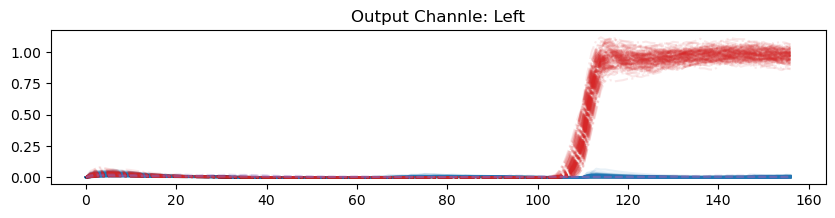

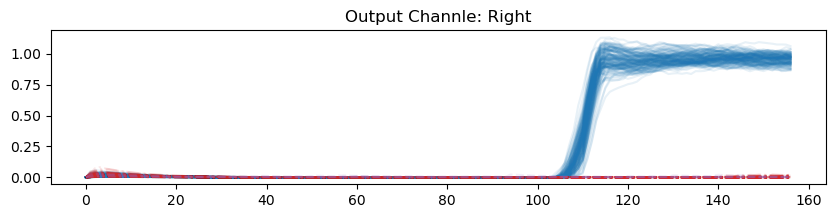

In [39]:
# visualize RNN output
n_r, n_l = task_params["n_rights"], task_params["n_lefts"]
n_c = task_params["n_catches"]
print(n_r, n_l, n_c)
ch_names = ["Left", "Right"]

for i in range(output_size): # left, right
    fig = plt.figure(figsize = (10, 2))
    plt.plot(output[i,:,:n_r], c='tab:blue', alpha=0.1)
    plt.plot(output[i,:,n_r:n_r+n_l], c='tab:red', ls="-.", alpha=0.1)
    plt.plot(output[i,:,n_r+n_l:n_c+n_r+n_l], c='tab:purple', ls="--", alpha=0.1)
    plt.title(f"Output Channle: {ch_names[i]}")

In [69]:
# rnn_trained, train_losses, val_losses, net_params
# save RNN data
RNN_valid.clear_history()
RNN_valid.run(input_batch_valid, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
neural_traces = RNN_valid.get_history()
traces_data = {}
traces_data["inputs"] = input_batch_valid
traces_data["targets"] = target_batch_valid
traces_data["traces"] = neural_traces
traces_data["outputs"] = RNN_valid.get_output()
traces_data["net_params"] = net_params

path_to_traces = os.path.join("../data/trained_RNNs/ALM/","test","trained_RNN_lambda_orth=2_in_out_orth.pkl")
pickle.dump(traces_data, open(path_to_traces, "wb+"))